In [1]:
from collections import defaultdict, Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from Bio.SeqIO import parse
from scipy.spatial.distance import pdist, squareform, euclidean

from utils import (
    prepare_exp_aa_subst, collect_possible_changes, 
    cdn_spectrum_to_matrix, possible_codons, amino_acid_codes,
    get_equilibrium_freqs, get_equilibrium_probabilities,
    prepare_exp_cdn_subst
)

In [2]:
# Assuming you have:
# transition_matrix - 64x64 numpy array
# initial_vector - 1x64 numpy array (or 64x1, will need to transpose if needed)

def simulate_markov(transition_matrix, initial_vector, num_iterations):
    current_state = initial_vector
    data = [current_state]
    for _ in range(num_iterations):
        current_state = np.dot(current_state, transition_matrix)
        data.append(current_state)
        # print(f"Current state after iteration: {current_state[:5]}")
    return data


def simulate_markov_power(transition_matrix, initial_vector, num_iterations):
    powered_matrix = np.linalg.matrix_power(transition_matrix, num_iterations)
    return np.dot(initial_vector, powered_matrix)

## test 2 approaches

In [3]:
clades_spectra = pd.read_csv('data/rates_by_clade.csv')
clades_spectra['Mut'] = clades_spectra['mut_type'].str.replace('to', '>')
spectrum_20A = clades_spectra[clades_spectra['clade'] == '20A'].copy()
spectrum_20A['rate'] /= spectrum_20A['rate'].sum()
spectrum_20A

,clade,mut_type,count,total_count,fraction,parent_nt,parent_nt_frac,rate,Mut
0,20A,AtoC,286,17202,0.016626,A,0.289620,0.007791,A>C
1,20A,AtoG,1617,17202,0.094001,A,0.289620,0.044050,A>G
2,20A,AtoT,515,17202,0.029938,A,0.289620,0.014029,A>T
3,20A,CtoA,339,17202,0.019707,C,0.137040,0.019518,C>A
4,20A,CtoG,130,17202,0.007557,C,0.137040,0.007484,C>G
5,20A,CtoT,7113,17202,0.413500,C,0.137040,0.409514,C>T
6,20A,GtoA,837,17202,0.048657,G,0.064987,0.101614,G>A
7,20A,GtoC,137,17202,0.007964,G,0.064987,0.016632,G>C
8,20A,GtoT,2670,17202,0.155210,G,0.064987,0.324148,G>T
9,20A,TtoA,565,17202,0.032845,T,0.508360,0.008769,T>A


In [4]:
from pymutspec.annotation import CodonAnnotation

# def get_equilibrium_freqs(spectrum: pd.DataFrame, rate_col='MutSpec', gc=1):
coda = CodonAnnotation(1)
df_changes = collect_possible_changes(1)
spectrum_dict = spectrum_20A.set_index('Mut')['rate'].to_dict()

df_changes['rate'] = df_changes['sbs'].map(spectrum_dict)

cdn_sbs = df_changes.groupby(['cdn1', 'cdn2'])['rate'].sum()
M = cdn_spectrum_to_matrix(cdn_sbs)
eq_prob = get_equilibrium_probabilities(M).astype(float)

eq_freqs_cdn = pd.Series(dict(zip(possible_codons, eq_prob)))
eq_freqs_cdn.name = 'eq_freq'
eq_freqs_cdn.index.name = 'cdn'
eq_freqs_cdn = eq_freqs_cdn.reset_index()
eq_freqs_cdn['aa'] = eq_freqs_cdn['cdn']\
    .map(coda.translate_codon).map(amino_acid_codes)

eq_freqs_aa = eq_freqs_cdn[eq_freqs_cdn.aa !='*'].groupby('aa')['eq_freq'].sum()
eq_freqs_aa /= eq_freqs_aa.sum()
eq_freqs_aa = eq_freqs_aa.sort_values(ascending=False).reset_index()

eq_cdn1, eq_aa1 = eq_freqs_cdn, eq_freqs_aa

/tmp/ipykernel_556277/1248810473.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  eq_prob = get_equilibrium_probabilities(M).astype(float)


In [5]:
#CDN
df_changes['rate'] = df_changes['sbs'].map(spectrum_dict)
exp_cdn_subst = cdn_sbs.reset_index()

Mcdn = exp_cdn_subst.pivot(index='cdn1', columns='cdn2', values='rate').fillna(0.)
Mcdn = (Mcdn.T / Mcdn.sum(axis=1)).T
# Mcdn = Mcdn / Mcdn.sum().sum()

aa_init_freqs = np.random.rand(len(Mcdn.columns))
aa_init_freqs = aa_init_freqs / aa_init_freqs.sum()

res_cdn = simulate_markov_power(Mcdn.values, aa_init_freqs, 1000)
# pd.DataFrame({'aa': Mcdn.columns, 'eq2': res_cdn})
res_cdn

array([2.95463048e-03, 3.77796575e-03, 1.46063545e-03, 1.27203193e-02,
       3.77796575e-03, 2.77558383e-03, 1.06875772e-03, 1.68693185e-02,
       1.46063545e-03, 1.06875772e-03, 4.11516605e-04, 6.52328396e-03,
       1.27203193e-02, 1.68693185e-02, 6.52328396e-03, 5.45859816e-02,
       3.77796575e-03, 2.77558383e-03, 1.06875772e-03, 1.68693185e-02,
       2.77558383e-03, 1.72137567e-03, 6.61660340e-04, 1.24869481e-02,
       1.06875772e-03, 6.61660340e-04, 2.54323139e-04, 4.80852885e-03,
       1.68693185e-02, 1.24869481e-02, 4.80852885e-03, 7.52971577e-02,
       1.46063545e-03, 1.06875772e-03, 4.11516605e-04, 6.52328396e-03,
       1.06875772e-03, 6.61660340e-04, 2.54323139e-04, 4.80852885e-03,
       4.11516605e-04, 2.54323139e-04, 9.77525401e-05, 1.85161608e-03,
       6.52328396e-03, 4.80852885e-03, 1.85161608e-03, 2.91229620e-02,
       1.27203193e-02, 1.68693185e-02, 6.52328396e-03, 5.45859816e-02,
       1.68693185e-02, 1.24869481e-02, 4.80852885e-03, 7.52971577e-02,
      

In [6]:
# eq_prob2 = get_equilibrium_probabilities(M).astype(float)
M[:5, :5]

array([[-0.00411688,  0.00040662,  0.00211697,  0.00018268,  0.00040662],
       [ 0.00016232, -0.01183867,  0.0003465 ,  0.00084001,  0.        ],
       [ 0.00091771,  0.00015593, -0.01196114,  0.00012772,  0.        ],
       [ 0.00029227,  0.00853154,  0.00675308, -0.00389499,  0.        ],
       [ 0.00016232,  0.        ,  0.        ,  0.        , -0.01183867]])

In [7]:
Mcdn.sum(1).sum()

np.float64(64.0)

In [8]:
Mcdn = exp_cdn_subst.pivot(index='cdn1', columns='cdn2', values='rate').fillna(0.)
# Mcdn = (Mcdn.T / Mcdn.sum(axis=1)).T
Mcdn = Mcdn / Mcdn.sum().sum()
# Mcdn.values[:5, :5].T

In [9]:
Mcdn.values[:5, :5]

array([[0.        , 0.00016232, 0.00091771, 0.00029227, 0.00016232],
       [0.00040662, 0.        , 0.00015593, 0.00853154, 0.        ],
       [0.00211697, 0.0003465 , 0.        , 0.00675308, 0.        ],
       [0.00018268, 0.00084001, 0.00012772, 0.        , 0.        ],
       [0.00040662, 0.        , 0.        , 0.        , 0.        ]])

In [25]:
def cdn_spectrum_to_matrix2(cdn_sbs):
    '''
    convert dictionary of mutation counts to mutation matrix
    '''
    n = len(possible_codons)
    M = np.zeros((n, n))
    for i1,cdn1 in enumerate(possible_codons):
        for i2,cdn2 in enumerate(possible_codons):
            if cdn1!=cdn2:
                val = cdn_sbs[(cdn1, cdn2)] if (cdn1, cdn2) in cdn_sbs.index else 0.
                M[i2,i1] = val
    # normalize off-diagonal rates (just for standardization, doesn't affect the results)
    # M /= M.sum()
    M /= M.sum(axis=0, keepdims=True)
    # will the diagonal with 'outflow' term to guarantee conservation of probability
    d = M.sum(axis=0)
    np.fill_diagonal(M,-d)
    return M

cdn_sbs = df_changes.groupby(['cdn1', 'cdn2'])['rate'].sum()
M = cdn_spectrum_to_matrix2(cdn_sbs)
eq_prob = get_equilibrium_probabilities(M).astype(float)

eq_freqs_cdn = pd.Series(dict(zip(possible_codons, eq_prob)))
eq_freqs_cdn.name = 'eq_freq'
eq_freqs_cdn.index.name = 'cdn'
eq_freqs_cdn = eq_freqs_cdn.reset_index()

/tmp/ipykernel_556277/160814893.py:22: ComplexWarning: Casting complex values to real discards the imaginary part
  eq_prob = get_equilibrium_probabilities(M).astype(float)


In [26]:
M[0, 1:].sum(), M[0].sum()

(np.float64(0.7747054063269248), np.float64(-0.22529459367307506))

In [29]:
M[:5, :5]

array([[-1.        ,  0.03434637,  0.17698713,  0.04690163,  0.03434637],
       [ 0.03942677, -1.        ,  0.02896914,  0.2156633 ,  0.        ],
       [ 0.22291268,  0.01317085, -1.        ,  0.03278977,  0.        ],
       [ 0.07099388,  0.72065041,  0.56458499, -1.        ,  0.        ],
       [ 0.03942677,  0.        ,  0.        ,  0.        , -1.        ]])

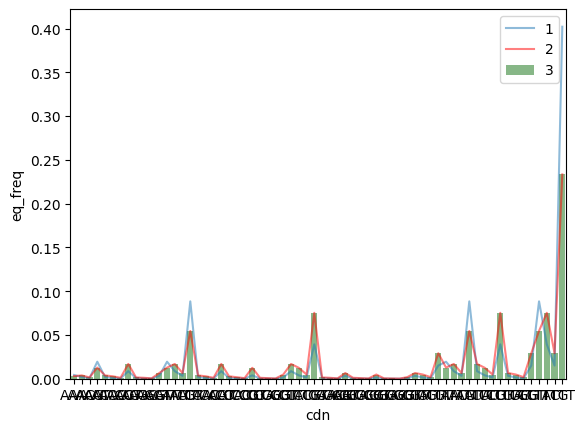

In [28]:
sns.lineplot(eq_cdn1, x='cdn', y='eq_freq', alpha=0.5, label='1')
sns.lineplot(pd.DataFrame({'cdn': Mcdn.columns, 'eq_freq': res_cdn}), 
             x='cdn', y='eq_freq', alpha=0.5, label='2', color='red')
sns.barplot(eq_freqs_cdn, x='cdn', y='eq_freq', alpha=0.5, label='3', color='g')

plt.legend()

## Main

### Load codon counts from refseq

In [4]:
data_cdn_counts = dict()

for rec in parse('./data/refseq_data/cds.fna', 'fasta'):
    if ' ORF1ab polyprotein ' in rec.description or ' ORF1a polyprotein ' in rec.description:
        print(' pass', rec.description)
    else:
        # print(rec.description, len(rec), len(rec) % 3)
        seq = str(rec.seq)
        codons = [seq[i:i+3] for i in range(0, len(rec), 3)]
        assert seq == ''.join(codons)
        gene = ' '.join(rec.description.split()[1:]).split(' [organism=')[0]

        print(gene, codons[-1], len(codons))

        data_cdn_counts[gene] = dict(Counter(codons))

3C-like proteinase [polyprotein=ORF1ab polyprotein] CAA 306
nsp6 [polyprotein=ORF1ab polyprotein] CAG 290
nsp7 [polyprotein=ORF1ab polyprotein] CAA 83
nsp8 [polyprotein=ORF1ab polyprotein] CAG 198
nsp9 [polyprotein=ORF1ab polyprotein] CAA 113
nsp10 [polyprotein=ORF1ab polyprotein] CAG 139
RNA-dependent RNA polymerase [polyprotein=ORF1ab polyprotein] CAG 932
nsp11 [polyprotein=ORF1a polyprotein] GTG 13
helicase [polyprotein=ORF1ab polyprotein] CAA 601
3'-to-5' exonuclease [polyprotein=ORF1ab polyprotein] CAG 527
endoRNAse [polyprotein=ORF1ab polyprotein] CAA 346
2'-O-ribose methyltransferase [polyprotein=ORF1ab polyprotein] AAC 298
surface glycoprotein TAA 1274
ORF3a protein TAA 276
envelope protein TAA 76
membrane glycoprotein TAA 223
 pass NC_045512.2:266-13468,13468-21555 ORF1ab polyprotein [organism=Severe acute respiratory syndrome coronavirus 2] [isolate=Wuhan-Hu-1]
 pass NC_045512.2:266-13483 ORF1a polyprotein [organism=Severe acute respiratory syndrome coronavirus 2] [isolate=Wu

In [5]:
cdn_counts_df = pd.DataFrame(data_cdn_counts).T.fillna(0).astype(int)
cdn_counts_df.to_csv('./data/refseq_data/codon_counts.csv')
cdn_counts_df.head()

,AGT,GGT,TTT,AGA,AAA,ATG,GCA,TTC,CCA,TCT,...,TCC,AGC,GCG,GGG,CCG,TCG,CGG,TAA,TGA,TAG
3C-like proteinase [polyprotein=ORF1ab polyprotein],3,17,12,3,3,10,3,5,5,7,...,0,0,0,0,0,0,0,0,0,0
nsp6 [polyprotein=ORF1ab polyprotein],4,11,17,6,8,17,5,5,1,7,...,1,1,0,0,0,0,0,0,0,0
nsp7 [polyprotein=ORF1ab polyprotein],0,1,1,1,4,4,1,0,0,3,...,1,0,0,0,0,0,0,0,0,0
nsp8 [polyprotein=ORF1ab polyprotein],5,3,4,3,8,9,10,1,2,5,...,1,0,0,0,0,0,0,0,0,0
nsp9 [polyprotein=ORF1ab polyprotein],3,6,3,2,4,2,2,1,1,1,...,1,0,1,0,0,0,0,0,0,0


In [6]:
cdn_counts_dct = cdn_counts_df.sum(0).to_dict()

In [7]:
cdn_counts_df.sum(axis=1).sort_values(ascending=False)

nsp3 [polyprotein=ORF1ab polyprotein]                             1945
surface glycoprotein                                              1274
RNA-dependent RNA polymerase [polyprotein=ORF1ab polyprotein]      932
nsp2 [polyprotein=ORF1ab polyprotein]                              638
helicase [polyprotein=ORF1ab polyprotein]                          601
3'-to-5' exonuclease [polyprotein=ORF1ab polyprotein]              527
nsp4 [polyprotein=ORF1ab polyprotein]                              500
nucleocapsid phosphoprotein                                        420
endoRNAse [polyprotein=ORF1ab polyprotein]                         346
3C-like proteinase [polyprotein=ORF1ab polyprotein]                306
2'-O-ribose methyltransferase [polyprotein=ORF1ab polyprotein]     298
nsp6 [polyprotein=ORF1ab polyprotein]                              290
ORF3a protein                                                      276
membrane glycoprotein                                              223
nsp8 [

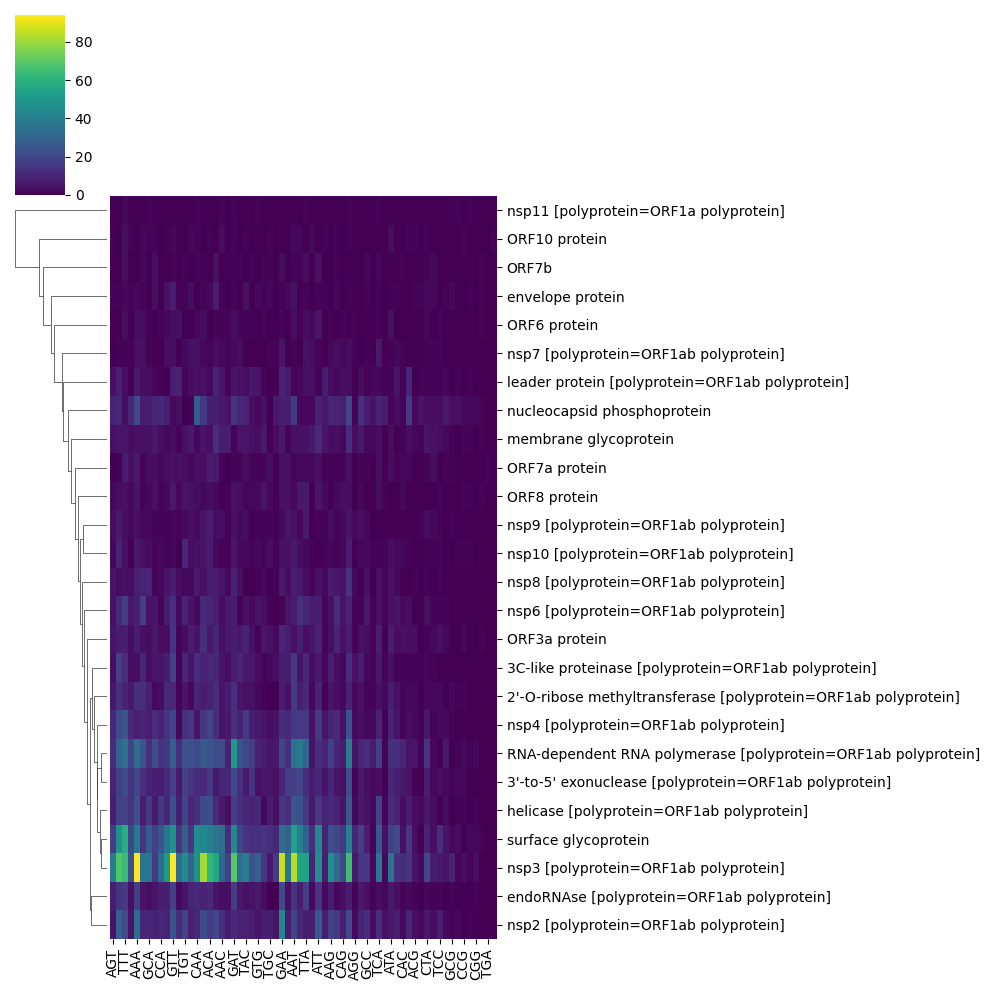

In [45]:
sns.clustermap(cdn_counts_df, cmap='viridis', figsize=(10, 10), metric='cosine',
               col_cluster=False, row_cluster=True, )

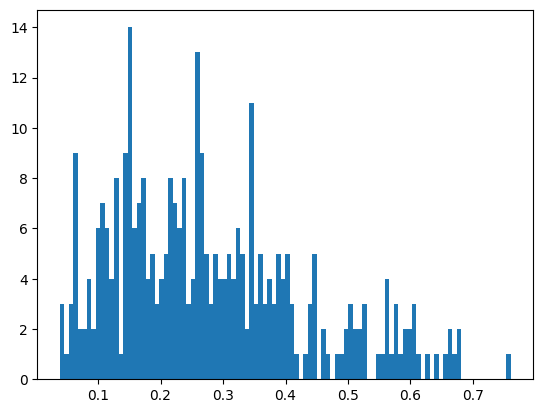

In [46]:
plt.hist(pdist(cdn_counts_df, 'cosine'), bins=100);

### Load matrix

In [8]:
clades_spectra = pd.read_csv('data/rates_by_clade.csv')
clades_spectra['Mut'] = clades_spectra['mut_type'].str.replace('to', '>')
spectrum_20A = clades_spectra[clades_spectra['clade'] == '20A'].copy()
spectrum_20A['rate'] /= spectrum_20A['rate'].sum()
spectrum_20A

,clade,mut_type,count,total_count,fraction,parent_nt,parent_nt_frac,rate,Mut
0,20A,AtoC,286,17202,0.016626,A,0.289620,0.007791,A>C
1,20A,AtoG,1617,17202,0.094001,A,0.289620,0.044050,A>G
2,20A,AtoT,515,17202,0.029938,A,0.289620,0.014029,A>T
3,20A,CtoA,339,17202,0.019707,C,0.137040,0.019518,C>A
4,20A,CtoG,130,17202,0.007557,C,0.137040,0.007484,C>G
5,20A,CtoT,7113,17202,0.413500,C,0.137040,0.409514,C>T
6,20A,GtoA,837,17202,0.048657,G,0.064987,0.101614,G>A
7,20A,GtoC,137,17202,0.007964,G,0.064987,0.016632,G>C
8,20A,GtoT,2670,17202,0.155210,G,0.064987,0.324148,G>T
9,20A,TtoA,565,17202,0.032845,T,0.508360,0.008769,T>A


In [9]:
possible_aa = list(amino_acid_codes.values())[:20]

In [10]:
eq_freq_df, _ = get_equilibrium_freqs(spectrum_20A, 'rate', gc=1)
eq_freq_vec_cdn = eq_freq_df.set_index('cdn').loc[possible_codons, 'eq_freq'].values
eq_freq_vec_aa = eq_freq_df.groupby('aa')['eq_freq'].sum().loc[possible_aa].values
eq_freq_vec_aa

array([0.00679327, 0.00866542, 0.01649829, 0.00759204, 0.03393149,
       0.00484672, 0.00187215, 0.00261521, 0.0196449 , 0.08417562,
       0.1931709 , 0.00441527, 0.00652328, 0.30868405, 0.01764557,
       0.11705399, 0.02449163, 0.00185162, 0.0714553 , 0.04230639])

### AA

In [14]:
_, Maa = prepare_exp_aa_subst(spectrum_20A)
Maa = (Maa.T / Maa.sum(axis=1)).T

In [15]:
Maa

aa2,Ala,Arg,Asn,Asp,Cys,Gln,Glu,Gly,His,Ile,Leu,Lys,Met,Phe,Pro,Ser,Thr,Trp,Tyr,Val
aa1,,,,,,,,,,,,,,,,,,,,
Ala,0.221452,0.000000,0.000000,0.008644,0.000000,0.000000,0.008644,0.006630,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014733,0.287133,0.090011,0.000000,0.000000,0.362752
Arg,0.000000,0.213691,0.000000,0.000000,0.145815,0.036182,0.000000,0.021015,0.036182,0.057709,0.230838,0.036182,0.057709,0.000000,0.011844,0.071505,0.005922,0.075405,0.000000,0.000000
Asn,0.000000,0.000000,0.595637,0.116655,0.000000,0.000000,0.000000,0.000000,0.020633,0.037153,0.000000,0.055482,0.000000,0.000000,0.000000,0.116655,0.020633,0.000000,0.037153,0.000000
Asp,0.010331,0.000000,0.134744,0.298246,0.000000,0.000000,0.027781,0.058411,0.022055,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.429829,0.018603
Cys,0.000000,0.055283,0.000000,0.000000,0.308385,0.000000,0.000000,0.008405,0.000000,0.000000,0.000000,0.000000,0.000000,0.444441,0.000000,0.034827,0.000000,0.009334,0.139324,0.000000
Gln,0.000000,0.126943,0.000000,0.000000,0.000000,0.209888,0.021569,0.000000,0.522472,0.000000,0.040429,0.056246,0.000000,0.000000,0.022453,0.000000,0.000000,0.000000,0.000000,0.000000
Glu,0.017778,0.000000,0.000000,0.413692,0.000000,0.037951,0.166189,0.100513,0.000000,0.000000,0.000000,0.231865,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.032012
Gly,0.015784,0.063999,0.000000,0.048216,0.153807,0.000000,0.048216,0.237247,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.048216,0.000000,0.076903,0.000000,0.307613
His,0.000000,0.058870,0.026084,0.010003,0.000000,0.027999,0.000000,0.000000,0.300589,0.000000,0.018749,0.000000,0.000000,0.000000,0.010412,0.000000,0.000000,0.000000,0.547293,0.000000


In [16]:
aa_init_freqs = {'Met': 207,
 'Glu': 442,
 'Ser': 661,
 'Leu': 930,
 'Val': 781,
 'Pro': 394,
 'Gly': 576,
 'Phe': 500,
 'Asn': 532,
 'Lys': 562,
 'Thr': 718,
 'His': 189,
 'Gln': 365,
 'Arg': 350,
 'Asp': 511,
 'Ala': 658,
 'Cys': 296,
 'Tyr': 448,
 'Ile': 513,
 'Trp': 111}

aa_init_freqs = np.array([aa_init_freqs[x] for x in Maa.columns])
aa_init_freqs = aa_init_freqs / aa_init_freqs.sum()
aa_init_freqs

array([0.06752874, 0.03591954, 0.0545977 , 0.05244253, 0.03037767,
       0.03745895, 0.04536125, 0.0591133 , 0.01939655, 0.05264778,
       0.09544335, 0.05767652, 0.02124384, 0.05131363, 0.04043514,
       0.06783662, 0.07368637, 0.01139163, 0.04597701, 0.08015189])

In [17]:
for i in range(10):
    d = euclidean(simulate_markov_power(Maa.values, aa_init_freqs, i), eq_freq_vec_aa)
    print(i, d)

res_aa = simulate_markov_power(Maa.values, aa_init_freqs, 10000)

euclidean(res_aa, eq_freq_vec_aa)

0 0.3184748724156978
1 0.23501009788884283
2 0.17884670166093886
3 0.14371672127160817
4 0.11978723048031117
5 0.1025992306355649
6 0.08986997825884
7 0.08031010887736838
8 0.07311641504315833
9 0.06773224307432714


0.05378092828103674

In [18]:
values, vectors = np.linalg.eig(Maa.values.T)
pi = vectors[:, np.isclose(values, 1)].real
pi = pi / pi.sum()
pi.flatten()

array([0.00615381, 0.00961757, 0.03127513, 0.00915547, 0.02682019,
       0.00274256, 0.00175694, 0.00418558, 0.01814157, 0.11565366,
       0.2067809 , 0.00541002, 0.01488244, 0.29771626, 0.01651341,
       0.08247588, 0.02873306, 0.00178199, 0.07662655, 0.04357702])

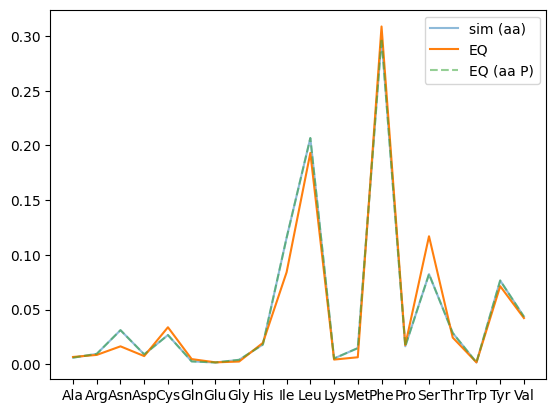

In [15]:
plt.plot(res_aa, label='sim (aa)', alpha=0.5)
plt.plot(eq_freq_vec_aa, label='EQ')
plt.plot(pi.flatten(), label='EQ (aa P)', linestyle='--', alpha=0.5)
plt.xticks(range(20), possible_aa)
plt.legend()

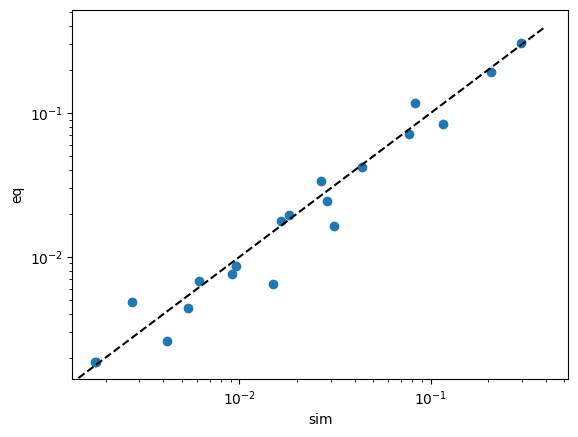

In [16]:
plt.scatter(res_aa, eq_freq_vec_aa)
plt.plot([0, 0.4], [0, 0.4], 'k--')
plt.xlabel('sim')
plt.ylabel('eq')
plt.xscale('log')
plt.yscale('log')

In [20]:
def simulate_markov_continual(transition_matrix, initial_vector, num_iterations, delta_t=0.01):
    pi = initial_vector.copy()
    data = [pi.copy()]
    Q = transition_matrix.copy()
    Q = Q - np.diag(np.sum(Q, axis=1))  # Convert to infinitesimal generator
    for _ in range(num_iterations):
        pi_new = pi + delta_t * (pi @ Q)
        pi_new = pi_new / pi_new.sum()
        data.append(pi_new.copy())
        if np.linalg.norm(pi_new - pi) < 1e-8:
            break
        pi = pi_new
    return data

In [21]:
sim_data = simulate_markov_continual(Maa.values, aa_init_freqs, 10, delta_t=0.01)
sim_data_df = pd.DataFrame(sim_data, columns=Maa.columns.values)
sim_data_df.index.name = 'replica'
sim_data_df_long = sim_data_df.melt(ignore_index=False, value_name='freq', var_name='aa').reset_index()
sim_data_df_long

,replica,aa,freq
0,0,Ala,0.067529
1,1,Ala,0.067119
2,2,Ala,0.066711
3,3,Ala,0.066307
4,4,Ala,0.065906
...,...,...,...
215,6,Val,0.080300
216,7,Val,0.080318
217,8,Val,0.080334
218,9,Val,0.080348


In [22]:
ref_freq_df = pd.DataFrame(
    {'replica':0, 'freq': dict(zip(possible_aa, aa_init_freqs))})\
        .reset_index(names='aa')
ref_freq_df.head()

,aa,replica,freq
0,Ala,0,0.067529
1,Arg,0,0.035920
2,Asn,0,0.054598
3,Asp,0,0.052443
4,Cys,0,0.030378


In [23]:
aa_content25 = pd.read_csv('./data/mean_aa_content_2025.csv', header=None, index_col=0)[1]
aa_content25 /= aa_content25.sum()
df_aa_content25 = aa_content25.sort_index().reset_index()
df_aa_content25.columns = ['aa', 'freq']
df_aa_content25['replica'] = -0.5
aa_content25vec = df_aa_content25['freq'].values
df_aa_content25

,aa,freq,replica
0,Ala,0.066920,-0.5
1,Arg,0.035798,-0.5
2,Asn,0.054159,-0.5
3,Asp,0.052431,-0.5
4,Cys,0.030503,-0.5
5,Gln,0.036961,-0.5
6,Glu,0.045344,-0.5
7,Gly,0.058903,-0.5
8,His,0.019772,-0.5
9,Ile,0.053464,-0.5


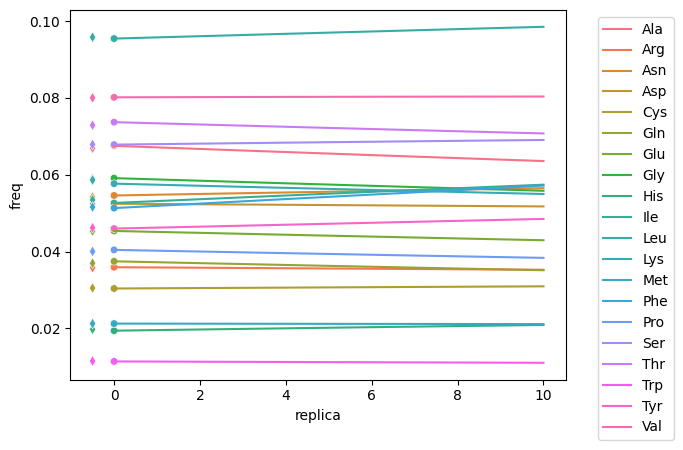

In [21]:
sns.lineplot(sim_data_df_long, x='replica', y='freq', hue='aa')
sns.scatterplot(ref_freq_df, hue='aa', x='replica', y='freq', legend=False, s=30)
sns.scatterplot(df_aa_content25, hue='aa', x='replica', y='freq', legend=False, s=30, marker='d')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

In [24]:
for i, p in enumerate(simulate_markov_continual(Maa.values, aa_init_freqs, 30, delta_t=0.0005)):
    print(i, np.linalg.norm(p - aa_content25.loc[Maa.columns.values].values)*1000)

0 1.9038514931114563
1 1.8722453530075602
2 1.8420849381810886
3 1.813440854400897
4 1.7863844928966848
5 1.7609874648815536
6 1.737320949428039
7 1.715454958296672
8 1.6954575256565614
9 1.6773938355094051
10 1.6613253047718568
11 1.6473086450257612
12 1.6353949304658857
13 1.6256287030659229
14 1.6180471479579979
15 1.6126793720641222
16 1.6095458168623649
17 1.6086578317546676
18 1.6100174280117485
19 1.6136172251339014
20 1.619440592324035
21 1.6274619783912698
22 1.6376474145922255
23 1.649955167400927
24 1.6643365125366665
25 1.680736598104169
26 1.6990953634919326
27 1.7193484815797253
28 1.741428294486605
29 1.7652647170922884
30 1.7907860873870374


In [49]:
df_change = pd.DataFrame([
    aa_init_freqs,
    simulate_markov_continual(Maa.values, aa_init_freqs, 18, delta_t=0.0005)[-1],
    aa_content25.loc[Maa.columns.values],
], index=['refseq', 'sim1', 'gisaid25'], columns=Maa.columns.values
).T

# df_change['PE'] = (df_change['sim1'] - df_change['refseq']) / df_change['refseq']

df_change['PE_exp'] = (df_change['sim1'] - df_change['refseq']) / df_change['refseq']*100
# df_change['PE_exp'] = df_change['PE_exp'] / df_change['PE_exp'].abs()
df_change['PE_obs'] = (df_change['gisaid25'] - df_change['refseq']) / df_change['refseq']*100
# df_change['PE_obs'] = df_change['PE_obs'] / df_change['PE_obs'].abs()
df_change['correct_direction'] = df_change['PE_exp'].gt(0) == df_change['PE_obs'].gt(0)# & \
    # df_change['PE_obs'].abs().gt(0.5)
df_change['PEdelta'] = (df_change['PE_exp'] - df_change['PE_obs']).abs()
df_change['err'] = df_change['PEdelta'] / df_change['PE_obs'].abs()
df_change['correct_direction'] = df_change['PEdelta'] < 1

df_change

,refseq,sim1,gisaid25,PE_exp,PE_obs,correct_direction,PEdelta,err
Ala,0.067529,0.067161,0.066920,-0.544932,-0.900926,True,0.355994,0.395142
Arg,0.035920,0.035860,0.035798,-0.164503,-0.337612,True,0.173109,0.512745
Asn,0.054598,0.054776,0.054159,0.325844,-0.803272,False,1.129117,1.405646
Asp,0.052443,0.052382,0.052431,-0.116250,-0.021631,True,0.094619,4.374147
Cys,0.030378,0.030431,0.030503,0.176335,0.413500,True,0.237165,0.573554
Gln,0.037459,0.037243,0.036961,-0.575241,-1.328163,True,0.752921,0.566890
Glu,0.045361,0.045138,0.045344,-0.491232,-0.037280,True,0.453952,12.176699
Gly,0.059113,0.058809,0.058903,-0.514754,-0.356420,True,0.158334,0.444235
His,0.019397,0.019538,0.019772,0.726867,1.933841,False,1.206974,0.624133
Ile,0.052648,0.053088,0.053464,0.835267,1.550883,True,0.715616,0.461425


In [51]:
df_change['err'].mean()

np.float64(1.6726915985495208)

<Axes: >

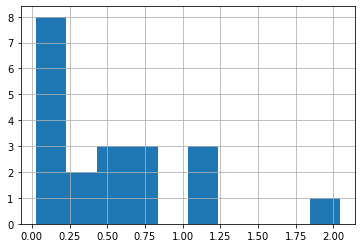

In [29]:
df_change['PEdelta'].hist()

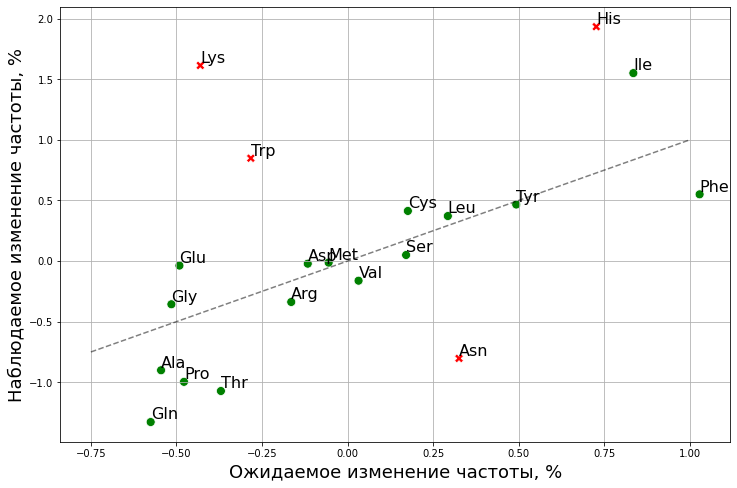

In [48]:
plt.figure(figsize=(12, 8))
sns.scatterplot(df_change, x='PE_exp', y='PE_obs', 
                style='correct_direction', hue='correct_direction',
                markers={True: 'o', False: 'X'}, s=80, legend=False,
                palette={True: 'green', False: 'red'})
plt.plot([-0.75, 1], [-0.75, 1], 'k--', alpha=0.5)
for aa, row in df_change.iterrows():
    plt.text(row['PE_exp'], row['PE_obs'], aa, fontsize=16, ha='left', va='bottom')
plt.grid()
# plt.xlabel('Predicted amino acid frequency change, %')
# plt.ylabel('Observed amino acid frequency change, %')
plt.xlabel('Ожидаемое изменение частоты, %', fontsize=18)
plt.ylabel('Наблюдаемое изменение частоты, %', fontsize=18)
# plt.xticks(np.arange(-100, 300, 50))
plt.savefig('./figures/aa_freqs_change_sim.pdf', bbox_inches='tight')
plt.show()

### CDN

In [33]:
# TEST

transition_matrix = np.array([
    [0.25, 0.5, 0.25],
    [0, 0.5, 0.5],
    [0.33, 0.33, 0.34]
])
initial_vector = np.array([0, 0.5, 0.5])  # Starting in state 0
simulate_markov_power(transition_matrix, initial_vector, 1)

array([0.165, 0.415, 0.42 ])

In [34]:
def prepare_exp_cdn_subst(spectrum: pd.DataFrame, rate_col='rate', gc=1, save_path=None):
    df_changes = collect_possible_changes(gc=gc)
    spectrum_dict = spectrum.set_index('Mut')[rate_col].to_dict()

    df_changes['rate'] = df_changes['sbs'].map(spectrum_dict)

    ## Calculate expected AA substitutions matrix
    exp_cdn_subst = df_changes[(df_changes.cdn1 != '*')&(df_changes.cdn2 != '*')]\
        .groupby(['cdn1', 'cdn2'])['rate'].sum().reset_index()
    
    if save_path:
        exp_cdn_subst.to_csv(save_path, float_format='%g', index=False)
    exp_cdn_subst_matrix = exp_cdn_subst.pivot(index='cdn1', columns='cdn2', values='rate').fillna(0.)
    exp_cdn_subst_matrix = exp_cdn_subst_matrix.loc[possible_codons, possible_codons]
    return exp_cdn_subst, exp_cdn_subst_matrix

In [35]:
_, exp_cdn_subst_matrix = prepare_exp_cdn_subst(spectrum_20A, 'rate', 1)
exp_cdn_subst_matrix = (exp_cdn_subst_matrix.T / exp_cdn_subst_matrix.sum(1)).T
# np.fill_diagonal(exp_cdn_subst_matrix, 0)
# exp_cdn_subst_matrix /= exp_cdn_subst_matrix.sum(axis=1)

In [36]:
values, vectors = np.linalg.eig(exp_cdn_subst_matrix.values.T)
pi = vectors[:, np.isclose(values, 1)].real
pi = pi / pi.sum()
pi.flatten()

array([2.95463048e-03, 3.77796575e-03, 1.46063545e-03, 1.27203193e-02,
       3.77796575e-03, 2.77558383e-03, 1.06875772e-03, 1.68693185e-02,
       1.46063545e-03, 1.06875772e-03, 4.11516605e-04, 6.52328396e-03,
       1.27203193e-02, 1.68693185e-02, 6.52328396e-03, 5.45859816e-02,
       3.77796575e-03, 2.77558383e-03, 1.06875772e-03, 1.68693185e-02,
       2.77558383e-03, 1.72137567e-03, 6.61660340e-04, 1.24869481e-02,
       1.06875772e-03, 6.61660340e-04, 2.54323139e-04, 4.80852885e-03,
       1.68693185e-02, 1.24869481e-02, 4.80852885e-03, 7.52971577e-02,
       1.46063545e-03, 1.06875772e-03, 4.11516605e-04, 6.52328396e-03,
       1.06875772e-03, 6.61660340e-04, 2.54323139e-04, 4.80852885e-03,
       4.11516605e-04, 2.54323139e-04, 9.77525401e-05, 1.85161608e-03,
       6.52328396e-03, 4.80852885e-03, 1.85161608e-03, 2.91229620e-02,
       1.27203193e-02, 1.68693185e-02, 6.52328396e-03, 5.45859816e-02,
       1.68693185e-02, 1.24869481e-02, 4.80852885e-03, 7.52971577e-02,
      

In [37]:
exp_cdn_subst_matrix.sum(1)

cdn1
AAA    1.0
AAC    1.0
AAG    1.0
AAT    1.0
ACA    1.0
      ... 
TGT    1.0
TTA    1.0
TTC    1.0
TTG    1.0
TTT    1.0
Length: 64, dtype: float64

In [38]:
Q = exp_cdn_subst_matrix.values
Q = Q - np.diag(np.sum(Q, axis=1))  # Convert to infinitesimal generator

values, vectors = np.linalg.eig(Q.T)
pi2 = vectors[:, np.isclose(values, 0)].real
pi2 = pi2 / pi2.sum()
pi2.flatten()

array([2.95463048e-03, 3.77796575e-03, 1.46063545e-03, 1.27203193e-02,
       3.77796575e-03, 2.77558383e-03, 1.06875772e-03, 1.68693185e-02,
       1.46063545e-03, 1.06875772e-03, 4.11516605e-04, 6.52328396e-03,
       1.27203193e-02, 1.68693185e-02, 6.52328396e-03, 5.45859816e-02,
       3.77796575e-03, 2.77558383e-03, 1.06875772e-03, 1.68693185e-02,
       2.77558383e-03, 1.72137567e-03, 6.61660340e-04, 1.24869481e-02,
       1.06875772e-03, 6.61660340e-04, 2.54323139e-04, 4.80852885e-03,
       1.68693185e-02, 1.24869481e-02, 4.80852885e-03, 7.52971577e-02,
       1.46063545e-03, 1.06875772e-03, 4.11516605e-04, 6.52328396e-03,
       1.06875772e-03, 6.61660340e-04, 2.54323139e-04, 4.80852885e-03,
       4.11516605e-04, 2.54323139e-04, 9.77525401e-05, 1.85161608e-03,
       6.52328396e-03, 4.80852885e-03, 1.85161608e-03, 2.91229620e-02,
       1.27203193e-02, 1.68693185e-02, 6.52328396e-03, 5.45859816e-02,
       1.68693185e-02, 1.24869481e-02, 4.80852885e-03, 7.52971577e-02,
      

In [47]:
transition_matrix = exp_cdn_subst_matrix.copy().values
# transition_matrix = transition_matrix / transition_matrix.sum(axis=1, keepdims=True)

initial_vector = np.array([cdn_counts_dct[x] for x in possible_codons])
initial_vector = initial_vector / initial_vector.sum()

eq_freq_df, _ = get_equilibrium_freqs(spectrum_20A, 'rate', gc=1)
eq_freq_vec = eq_freq_df.set_index('cdn').loc[possible_codons, 'eq_freq'].values

# Run 10 iterations
print(euclidean(initial_vector, eq_freq_vec))
# for i in range(10):
#     result = simulate_markov_power(transition_matrix, initial_vector, i)
#     print(euclidean(result, eq_freq_vec))
result = simulate_markov_power(transition_matrix, initial_vector, 10)
# print(euclidean(result, eq_freq_vec))
# print(eq_freq_vec.sum(), initial_vector.sum(), result.sum(), result.round(3))

0.24609335865624904


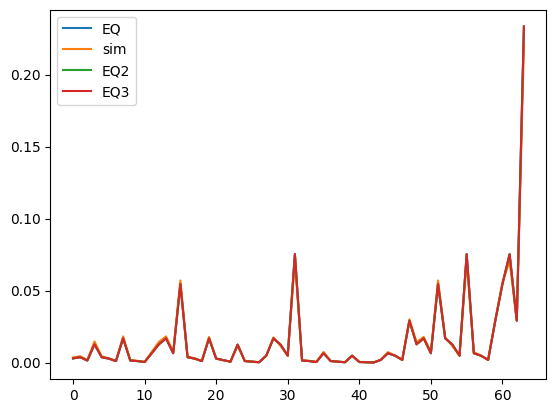

In [48]:
plt.plot(eq_freq_vec_cdn, label='EQ')
plt.plot(result, label='sim')
plt.plot(pi.flatten(), label='EQ2')
plt.plot(pi2.flatten(), label='EQ3')
plt.legend()

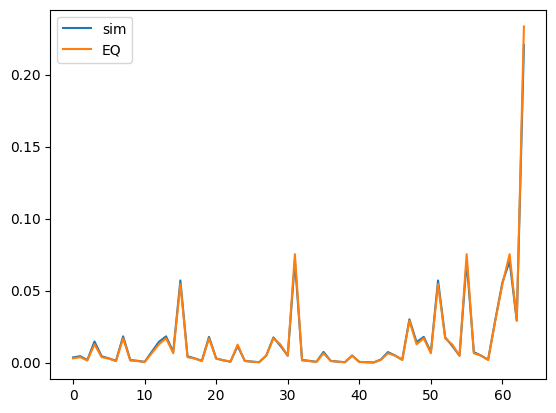

In [49]:
plt.plot(result, label='sim')
plt.plot(eq_freq_vec, label='EQ')
plt.legend()

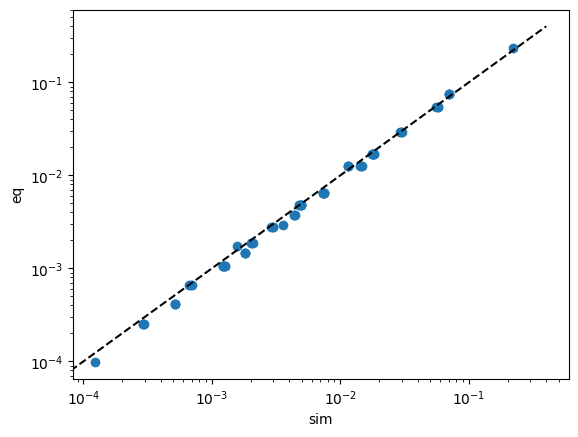

In [50]:
plt.scatter(result, eq_freq_vec)
plt.plot([0, 0.4], [0, 0.4], 'k--')
plt.xlabel('sim')
plt.ylabel('eq')
plt.xscale('log')
plt.yscale('log')

In [51]:
# Run 100 iterations
result = simulate_markov_power(transition_matrix, initial_vector, 1)
print(result)

[0.01719978 0.01315482 0.01231871 0.04009193 0.00909243 0.00471134
 0.00486378 0.01792896 0.01149017 0.00392896 0.00348922 0.01811899
 0.04379624 0.01395602 0.01019252 0.06675954 0.00484656 0.00379414
 0.00287485 0.01787515 0.00361579 0.00191485 0.00133724 0.00672789
 0.002924   0.00122457 0.00127944 0.0054583  0.01657131 0.00561309
 0.00392872 0.02922717 0.01297181 0.00575179 0.00493178 0.02819171
 0.00531696 0.00292519 0.00197365 0.01087748 0.00470893 0.00286633
 0.00182684 0.00884619 0.01992313 0.01021806 0.00528433 0.04661975
 0.04393466 0.01704679 0.01263976 0.05214291 0.020706   0.00684368
 0.00447058 0.03619023 0.0083943  0.00726464 0.00139915 0.03169412
 0.03889469 0.0238949  0.01917556 0.10176765]
